## Neste documento, adicionaremos a tag legal/ilegal nos dados
- Importação dos dados
- Divisão por grupo de tipo de licitação
- Criação do algorítmo de classificação
- Implementação nas bases divididas por modalidade de licitação

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%time
path = r'C:\licitacoes_2020'
filenames = glob.glob(path + "/*.csv")

li= []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0, decimal=',',sep=';',encoding='latin1')
    li.append(df)

df_lic_2020 = pd.concat(li, axis=0, ignore_index=True)

Wall time: 0 ns


In [3]:
pd.options.display.max_colwidth = 1000

In [4]:
df_lic_2020.head(1)

,Número Licitação,Código UG,Nome UG,Código Modalidade Compra,Modalidade Compra,Número Processo,Objeto,Situação Licitação,Código Órgão Superior,Nome Órgão Superior,Código Órgão,Nome Órgão,Município,Data Resultado Compra,Data Abertura,Valor Licitação
0,12018,925206,PMSP - DIR. REG. EDUC. - SÃO MATEUS,5,Pregão,6016201800295980,"Objeto: Pregão Eletrônico - Contratação de empresa especializada na prestação de serviço de limpeza, conservação, desinsetização, desratização, limpeza das caixas d água e copeiragem com o fornecimento de mão-de-obra, saneantes domissanitários, incluindo o fornecimento de materiais e equipamentos segundo Anexo I, para a sede da Diretoria Regional de Educação São Mateus Av. Ragueb Chohfi, 1550 Jd. Três Marias São Paulo - SP.",Divulgado,99900,REPUBLICA FEDERATIVA DO BRASIL,95420,ESTADO DE SAO PAULO,Inválido,21/01/2020,13/07/2018,448622.52


In [5]:
df_lic_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157373 entries, 0 to 157372
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          157373 non-null  int64  
 1   Código UG                 157373 non-null  int64  
 2   Nome UG                   157373 non-null  object 
 3   Código Modalidade Compra  157373 non-null  int64  
 4   Modalidade Compra         157373 non-null  object 
 5   Número Processo           157373 non-null  object 
 6   Objeto                    157373 non-null  object 
 7   Situação Licitação        157373 non-null  object 
 8   Código Órgão Superior     157373 non-null  int64  
 9   Nome Órgão Superior       157373 non-null  object 
 10  Código Órgão              157373 non-null  int64  
 11  Nome Órgão                157373 non-null  object 
 12  Município                 157373 non-null  object 
 13  Data Resultado Compra     157373 non-null  o

In [6]:
df_lic_2020.shape

(157373, 16)

In [7]:
df_lic_2020.rename(columns={"Valor Licitação": "Total"},inplace=True)

In [8]:
df_lic_2020['Modalidade Compra'].value_counts()

Dispensa de Licitação               102062
Pregão - Registro de Preço           20084
Inexigibilidade de Licitação         17393
Pregão                               16905
Tomada de Preços                       718
Concorrência                           138
Convite                                 60
Concurso                                 8
Concorrência - Registro de Preço         4
Concorrência Internacional               1
Name: Modalidade Compra, dtype: int64

In [9]:
a = df_lic_2020['Data Resultado Compra'].value_counts()

## É Obra ?

In [10]:
df_lic_2020['Obras'] = df_lic_2020['Objeto'].str.contains("OBRAS|OBRA|obras|obra|ENGENHARIA|engenharia|CONSTRU-CAO|constru-cao", na=False)

In [11]:
df_lic_2020['Obras'].value_counts()

False    152218
True       5155
Name: Obras, dtype: int64

In [12]:
df_lic_2020['Tipo'] = 1

In [13]:
df_lic_2020.loc[df_lic_2020['Obras'] == True, 'Tipo'] = 'Obras'
df_lic_2020.loc[df_lic_2020['Obras'] == False, 'Tipo'] = 'Compras/Servicos'

In [14]:
df_lic_2020['Tipo'].value_counts()

Compras/Servicos    152218
Obras                 5155
Name: Tipo, dtype: int64

In [15]:
#Excluindo o atributo Obras que não será utilizado nas análises posteriores.
df_lic_2020.drop(columns=['Obras'], axis=1, inplace=True)

In [16]:
df_lic_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157373 entries, 0 to 157372
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          157373 non-null  int64  
 1   Código UG                 157373 non-null  int64  
 2   Nome UG                   157373 non-null  object 
 3   Código Modalidade Compra  157373 non-null  int64  
 4   Modalidade Compra         157373 non-null  object 
 5   Número Processo           157373 non-null  object 
 6   Objeto                    157373 non-null  object 
 7   Situação Licitação        157373 non-null  object 
 8   Código Órgão Superior     157373 non-null  int64  
 9   Nome Órgão Superior       157373 non-null  object 
 10  Código Órgão              157373 non-null  int64  
 11  Nome Órgão                157373 non-null  object 
 12  Município                 157373 non-null  object 
 13  Data Resultado Compra     157373 non-null  o

# Separando as Licitações por Modalidade de Compra e aplicando as regras de acordo com os valores a partir do Decreto n. 9.412, de 18 de Junho de 2020.

## Registro de Preço/ Concorrência/Concorrência - Registro de Preço

In [17]:
df_lic_2020_RP = df_lic_2020[(df_lic_2020['Modalidade Compra']  == 'Pregão - Registro de Preço') | (df_lic_2020['Modalidade Compra'] == 'Concorrência - Registro de Preço') | (df_lic_2020['Modalidade Compra'] == 'Concorrência')]

In [18]:
df_lic_2020_RP['Modalidade Compra'].value_counts()

Pregão - Registro de Preço          20084
Concorrência                          138
Concorrência - Registro de Preço        4
Name: Modalidade Compra, dtype: int64

In [19]:
df_lic_2020_RP['Tipo'].value_counts()

Compras/Servicos    19686
Obras                 540
Name: Tipo, dtype: int64

In [20]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_RP_2020 = df_lic_2020_RP[df_lic_2020_RP['Tipo'] == 'Obras']
lic_compras_RP_2020 = df_lic_2020_RP[df_lic_2020_RP['Tipo'] != 'Obras']

## Tag'ando como legal ou ilegal de acordo  com Decreto nº 9.412, de 18 de Junho de 2020

#### 0: ilegal
#### 1: legal

In [21]:
lic_obras_RP_2020['Tag'] = 0
lic_compras_RP_2020['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/3692778047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_RP_2020['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/3692778047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_RP_2020['Tag'] = 0


In [22]:
#regra de limite de valor
#Considerando REGISTRO DE PREÇO como CONCORRENCIA e CONCORRENCIA - REGISTRO DE PREÇO
lic_obras_RP_2020.loc[lic_obras_RP_2020['Total'] > 3300000, 'Tag'] = 1
lic_compras_RP_2020.loc[lic_compras_RP_2020['Total'] > 1430000, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [23]:
lic_obras_RP_2020['Tag'].value_counts()

0    485
1     55
Name: Tag, dtype: int64

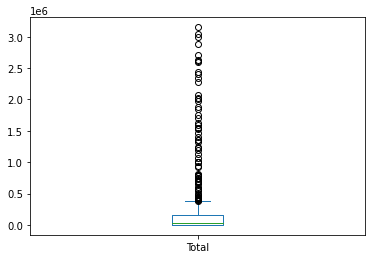

In [24]:
# Análise visual das licitações Ilegais para esta modalidade
lic_obras_RP_2020[lic_obras_RP_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [25]:
lic_obras_RP_2020[lic_obras_RP_2020['Tag'] == 0]['Total'].describe()

count    4.850000e+02
mean     2.341066e+05
std      5.355718e+05
min      0.000000e+00
25%      1.875200e+03
50%      2.720000e+04
75%      1.514133e+05
max      3.151678e+06
Name: Total, dtype: float64

<AxesSubplot:>

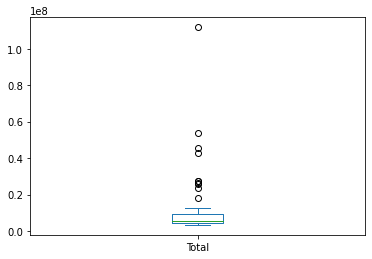

In [26]:
lic_obras_RP_2020[lic_obras_RP_2020['Tag'] == 1]['Total'].plot.box()

In [27]:
lic_compras_RP_2020['Tag'].value_counts()

0    19179
1      507
Name: Tag, dtype: int64

<AxesSubplot:>

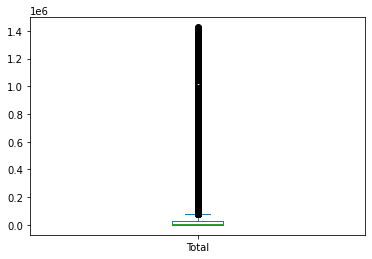

In [28]:
# Visualizando as licitações do tipo Registro de Preço que foram Ilegais
lic_compras_RP_2020[lic_compras_RP_2020['Tag'] == 0]['Total'].plot.box()

In [29]:
lic_compras_RP_2020[lic_compras_RP_2020['Tag'] == 0]['Total'].describe()

count    1.917900e+04
mean     5.648963e+04
std      1.584360e+05
min      0.000000e+00
25%      1.223750e+02
50%      4.860000e+03
75%      3.170250e+04
max      1.425600e+06
Name: Total, dtype: float64

<AxesSubplot:>

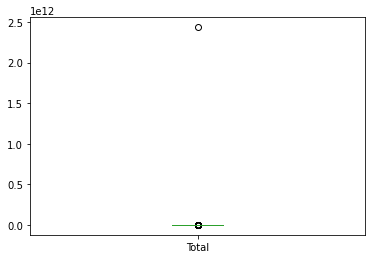

In [30]:
# Visualizando as licitações do tipo Registro de Preço que foram Legais
lic_compras_RP_2020[lic_compras_RP_2020['Tag'] == 1]['Total'].plot.box()

In [31]:
lic_compras_RP_2020[lic_compras_RP_2020['Tag'] == 1]['Total'].describe()

count    5.070000e+02
mean     4.813290e+09
std      1.081114e+11
min      1.432000e+06
25%      2.131722e+06
50%      4.128000e+06
75%      8.399413e+06
max      2.434320e+12
Name: Total, dtype: float64

## Dispensa de Licitação

In [32]:
df_lic_2020_Dispensa = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Dispensa de Licitação']

In [33]:
df_lic_2020_Dispensa['Modalidade Compra'].value_counts()

Dispensa de Licitação    102062
Name: Modalidade Compra, dtype: int64

In [34]:
df_lic_2020_Dispensa['Tipo'].value_counts()

Compras/Servicos    100000
Obras                 2062
Name: Tipo, dtype: int64

In [35]:
lic_obras_Dispensa_2020 = df_lic_2020_Dispensa[df_lic_2020_Dispensa['Tipo'] == 'Obras']
lic_compras_Dispensa_2020 = df_lic_2020_Dispensa[df_lic_2020_Dispensa['Tipo'] != 'Obras']

In [36]:
lic_obras_Dispensa_2020['Tipo'].value_counts()

Obras    2062
Name: Tipo, dtype: int64

In [37]:
lic_compras_Dispensa_2020['Tipo'].value_counts()

Compras/Servicos    100000
Name: Tipo, dtype: int64

## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2020

#### 0: ilegal
#### 1: legal

In [38]:
lic_obras_Dispensa_2020['Tag'] = 0
lic_compras_Dispensa_2020['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/2119701332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Dispensa_2020['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/2119701332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Dispensa_2020['Tag'] = 0


In [39]:
#regra de limite de valor
lic_obras_Dispensa_2020.loc[lic_obras_Dispensa_2020['Total'] <= 33000 , 'Tag'] = 1
lic_compras_Dispensa_2020.loc[lic_compras_Dispensa_2020['Total'] <= 17600, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
lic_obras_Dispensa_2020['Tag'].value_counts()

1    1596
0     466
Name: Tag, dtype: int64

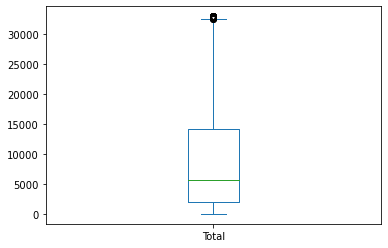

In [41]:
lic_obras_Dispensa_2020[lic_obras_Dispensa_2020['Tag'] == 1]['Total'].plot.box()
plt.show()

In [42]:
lic_obras_Dispensa_2020[lic_obras_Dispensa_2020['Tag'] == 1]['Total'].describe()

count     1596.000000
mean      9189.964505
std       9031.600611
min          0.000000
25%       1980.750000
50%       5667.000000
75%      14197.500000
max      33000.000000
Name: Total, dtype: float64

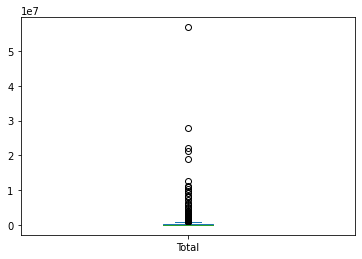

In [43]:
lic_obras_Dispensa_2020[lic_obras_Dispensa_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [44]:
lic_obras_Dispensa_2020[lic_obras_Dispensa_2020['Tag'] == 0]['Total'].describe()

count    4.660000e+02
mean     9.465799e+05
std      3.674913e+06
min      3.321000e+04
25%      5.103015e+04
50%      9.917494e+04
75%      4.239157e+05
max      5.683217e+07
Name: Total, dtype: float64

In [45]:
lic_compras_Dispensa_2020['Tag'].value_counts()

1    85462
0    14538
Name: Tag, dtype: int64

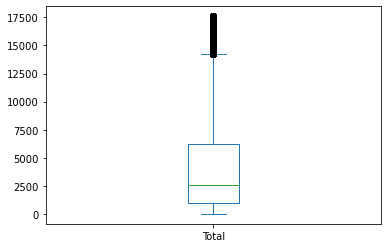

In [46]:
lic_compras_Dispensa_2020[lic_compras_Dispensa_2020['Tag'] == 1]['Total'].plot.box()
plt.show()

In [47]:
lic_compras_Dispensa_2020[lic_compras_Dispensa_2020['Tag'] == 1]['Total'].describe()

count    85462.000000
mean      4337.759326
std       4511.700014
min          0.000000
25%        966.000000
50%       2537.335000
75%       6264.705000
max      17600.000000
Name: Total, dtype: float64

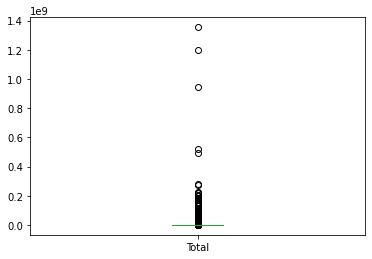

In [48]:
lic_compras_Dispensa_2020[lic_compras_Dispensa_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [49]:
lic_compras_Dispensa_2020[lic_compras_Dispensa_2020['Tag'] == 0]['Total'].describe()

count    1.453800e+04
mean     1.246876e+06
std      1.982053e+07
min      1.760125e+04
25%      2.699964e+04
50%      4.624500e+04
75%      1.638636e+05
max      1.353826e+09
Name: Total, dtype: float64

## Tomada de Preço

In [50]:
df_lic_2020_tomada_de_preco = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Tomada de Preços']

In [51]:
df_lic_2020_tomada_de_preco['Modalidade Compra'].value_counts()

Tomada de Preços    718
Name: Modalidade Compra, dtype: int64

In [52]:
df_lic_2020_tomada_de_preco['Tipo'].value_counts()

Compras/Servicos    435
Obras               283
Name: Tipo, dtype: int64

In [53]:
lic_obras_tomada_de_preco_2020 = df_lic_2020_tomada_de_preco[df_lic_2020_tomada_de_preco['Tipo'] == 'Obras']
lic_compras_tomada_de_preco_2020 = df_lic_2020_tomada_de_preco[df_lic_2020_tomada_de_preco['Tipo'] != 'Obras']

In [54]:
lic_obras_tomada_de_preco_2020['Tipo'].value_counts()

Obras    283
Name: Tipo, dtype: int64

In [55]:
lic_compras_tomada_de_preco_2020['Tipo'].value_counts()

Compras/Servicos    435
Name: Tipo, dtype: int64

In [56]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2020

#### 0: ilegal
#### 1: legal

lic_obras_tomada_de_preco_2020['Tag'] = 0
lic_compras_tomada_de_preco_2020['Tag'] = 0

#regra de limite de valor
lic_obras_tomada_de_preco_2020.loc[(lic_obras_tomada_de_preco_2020['Total'] >  330000) & (lic_obras_tomada_de_preco_2020['Total'] <=   3300000) , 'Tag'] = 1
lic_compras_tomada_de_preco_2020.loc[(lic_compras_tomada_de_preco_2020['Total'] >  176000) & (lic_compras_tomada_de_preco_2020['Total'] <=  1400000), 'Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/1576999121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_tomada_de_preco_2020['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/1576999121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_tomada_de_preco_2020['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [57]:
lic_obras_tomada_de_preco_2020['Tag'].value_counts()

1    156
0    127
Name: Tag, dtype: int64

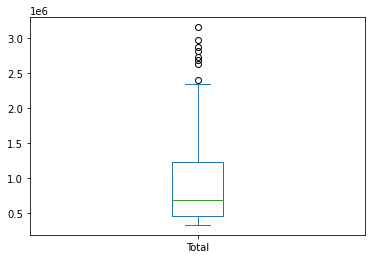

In [58]:
lic_obras_tomada_de_preco_2020[lic_obras_tomada_de_preco_2020['Tag'] == 1]['Total'].plot.box()
plt.show()

In [59]:
lic_obras_tomada_de_preco_2020[lic_obras_tomada_de_preco_2020['Tag'] == 1]['Total'].describe()

count    1.560000e+02
mean     9.538511e+05
std      6.515488e+05
min      3.324993e+05
25%      4.659162e+05
50%      6.817872e+05
75%      1.225781e+06
max      3.159088e+06
Name: Total, dtype: float64

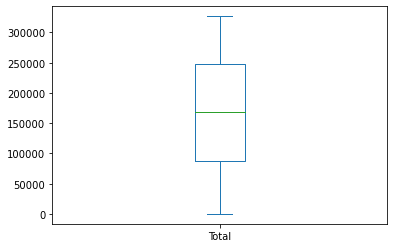

In [60]:
lic_obras_tomada_de_preco_2020[lic_obras_tomada_de_preco_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [61]:
lic_compras_tomada_de_preco_2020['Tag'].value_counts()

1    283
0    152
Name: Tag, dtype: int64

In [62]:
# Licitaçoes Legais
lic_compras_tomada_de_preco_2020[lic_compras_tomada_de_preco_2020['Tag'] == 1]['Total'].describe()

count    2.830000e+02
mean     5.515468e+05
std      3.217225e+05
min      1.766777e+05
25%      3.004545e+05
50%      4.445765e+05
75%      7.376809e+05
max      1.396531e+06
Name: Total, dtype: float64

In [63]:
lic_compras_tomada_de_preco_2020[lic_compras_tomada_de_preco_2020['Tag'] == 1]['Total'].describe()

count    2.830000e+02
mean     5.515468e+05
std      3.217225e+05
min      1.766777e+05
25%      3.004545e+05
50%      4.445765e+05
75%      7.376809e+05
max      1.396531e+06
Name: Total, dtype: float64

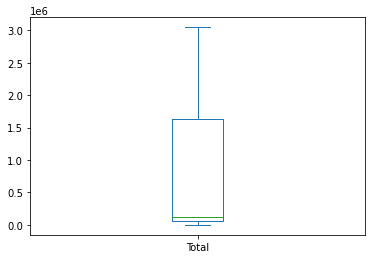

In [64]:
# Licitações Ilegais
lic_compras_tomada_de_preco_2020[lic_compras_tomada_de_preco_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [65]:
lic_compras_tomada_de_preco_2020[lic_compras_tomada_de_preco_2020['Tag'] == 0]['Total'].describe()

count    1.520000e+02
mean     6.928322e+05
std      9.267593e+05
min      0.000000e+00
25%      6.368863e+04
50%      1.197264e+05
75%      1.629016e+06
max      3.048457e+06
Name: Total, dtype: float64

## Convite

In [66]:
df_lic_2020_convite = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Convite']

In [67]:
df_lic_2020_convite['Modalidade Compra'].value_counts()

Convite    60
Name: Modalidade Compra, dtype: int64

In [68]:
df_lic_2020_convite['Tipo'].value_counts()

Compras/Servicos    33
Obras               27
Name: Tipo, dtype: int64

In [69]:
lic_compras_convite_2020 = df_lic_2020_convite[df_lic_2020_convite['Tipo'] != 'Obras']
lic_obras_convite_2020 = df_lic_2020_convite[df_lic_2020_convite['Tipo'] == 'Obras']

In [70]:
lic_compras_convite_2020['Tipo'].value_counts()

Compras/Servicos    33
Name: Tipo, dtype: int64

In [71]:
lic_obras_convite_2020['Tipo'].value_counts()

Obras    27
Name: Tipo, dtype: int64

In [72]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2020

#### 0: ilegal
#### 1: legal

lic_compras_convite_2020['Tag'] = 0
lic_obras_convite_2020['Tag'] = 0

#regra de limite de valor
lic_compras_convite_2020.loc[(lic_compras_convite_2020['Total'] >  17600) & (lic_compras_convite_2020['Total'] <=   176000) , 'Tag'] = 1
lic_obras_convite_2020.loc[(lic_obras_convite_2020['Total'] >  33000) & (lic_obras_convite_2020['Total'] <=   330000), 'Tag'] = 1


C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/4180678550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_convite_2020['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/4180678550.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_convite_2020['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [73]:
lic_compras_convite_2020['Tag'].value_counts()

1    22
0    11
Name: Tag, dtype: int64

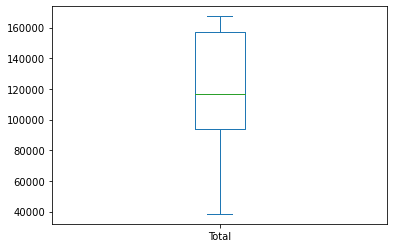

In [74]:
lic_compras_convite_2020[lic_compras_convite_2020['Tag'] == 1]['Total'].plot.box()
plt.show()

In [75]:
lic_compras_convite_2020[lic_compras_convite_2020['Tag'] == 1]['Total'].describe()

count        22.000000
mean     117724.997727
std       39179.390574
min       38496.670000
25%       94036.072500
50%      116743.980000
75%      156978.020000
max      167398.000000
Name: Total, dtype: float64

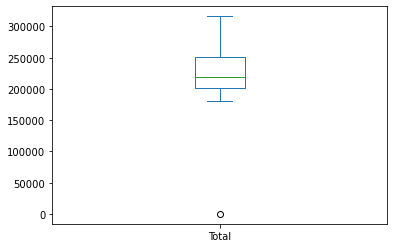

In [76]:
lic_compras_convite_2020[lic_compras_convite_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [77]:
lic_compras_convite_2020[lic_compras_convite_2020['Tag'] == 0]['Total'].describe()

count        11.000000
mean     213649.590000
std       81168.597312
min           0.000000
25%      201134.765000
50%      219163.530000
75%      251092.780000
max      316342.460000
Name: Total, dtype: float64

In [78]:
lic_obras_convite_2020['Tag'].value_counts()

1    25
0     2
Name: Tag, dtype: int64

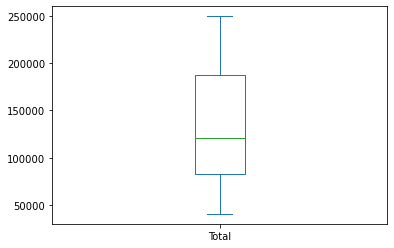

In [79]:
lic_obras_convite_2020[lic_obras_convite_2020['Tag'] == 1]['Total'].plot.box()
plt.show()

In [80]:
lic_obras_convite_2020[lic_obras_convite_2020['Tag'] == 1]['Total'].describe()

count        25.000000
mean     131794.173600
std       61060.837994
min       40653.950000
25%       82823.570000
50%      120680.260000
75%      187929.970000
max      249576.390000
Name: Total, dtype: float64

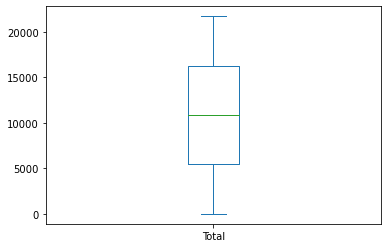

In [81]:
lic_obras_convite_2020[lic_obras_convite_2020['Tag'] == 0]['Total'].plot.box()
plt.show()

In [82]:
lic_obras_convite_2020[lic_obras_convite_2020['Tag'] == 0]['Total'].describe()

count        2.000000
mean     10846.645000
std      15339.472465
min          0.000000
25%       5423.322500
50%      10846.645000
75%      16269.967500
max      21693.290000
Name: Total, dtype: float64

### As modalidades abaixo não possuem uma regra bem definida para os valores de Licitação. Dessa forma, será atribuido a tag legal como padrão.

## Pregão

In [83]:
df_lic_2020_Pregao = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Pregão']

In [84]:
df_lic_2020_Pregao['Modalidade Compra'].value_counts()

Pregão    16905
Name: Modalidade Compra, dtype: int64

In [85]:
df_lic_2020_Pregao['Tipo'].value_counts()

Compras/Servicos    15167
Obras                1738
Name: Tipo, dtype: int64

In [86]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Pregao_2020 = df_lic_2020_Pregao[df_lic_2020_Pregao['Tipo'] == 'Obras']
lic_compras_Pregao_2020 = df_lic_2020_Pregao[df_lic_2020_Pregao['Tipo'] != 'Obras']

In [87]:
lic_obras_Pregao_2020['Tipo'].value_counts()

Obras    1738
Name: Tipo, dtype: int64

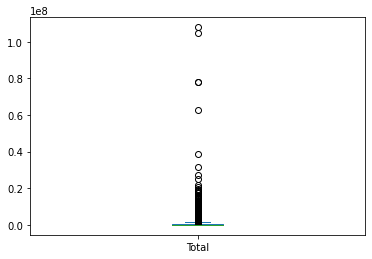

In [88]:
lic_obras_Pregao_2020['Total'].plot.box()
plt.show()

In [89]:
lic_obras_Pregao_2020['Total'].describe()

count    1.738000e+03
mean     1.306782e+06
std      5.428531e+06
min      0.000000e+00
25%      6.059567e+04
50%      2.194603e+05
75%      7.291299e+05
max      1.079070e+08
Name: Total, dtype: float64

In [90]:
lic_compras_Pregao_2020['Tipo'].value_counts()

Compras/Servicos    15167
Name: Tipo, dtype: int64

<AxesSubplot:>

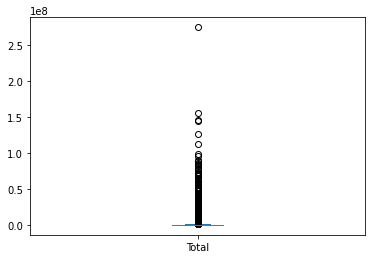

In [91]:
lic_compras_Pregao_2020['Total'].plot.box()

In [92]:
lic_compras_Pregao_2020['Total'].describe()

count    1.516700e+04
mean     1.031128e+06
std      5.692679e+06
min      0.000000e+00
25%      1.400000e+04
50%      6.755400e+04
75%      3.085507e+05
max      2.747000e+08
Name: Total, dtype: float64

In [93]:
## Tag'ando como legal já que não existe uma regra bem definida para a modalidade Pregão

#### 0: ilegal
#### 1: legal
lic_obras_Pregao_2020['Tag'] = 1
lic_compras_Pregao_2020['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/3164905057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Pregao_2020['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/3164905057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Pregao_2020['Tag'] = 1


In [94]:
lic_obras_Pregao_2020['Tag'].value_counts()

1    1738
Name: Tag, dtype: int64

In [95]:
lic_compras_Pregao_2020['Tag'].value_counts()

1    15167
Name: Tag, dtype: int64

## Inexigibilidade de Licitação 

In [96]:
df_lic_2020_Inex_2020 = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Inexigibilidade de Licitação']

In [97]:
df_lic_2020_Inex_2020['Modalidade Compra'].value_counts()

Inexigibilidade de Licitação    17393
Name: Modalidade Compra, dtype: int64

In [98]:
df_lic_2020_Inex_2020['Tipo'].value_counts()

Compras/Servicos    16889
Obras                 504
Name: Tipo, dtype: int64

In [99]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Inex_2020 = df_lic_2020_Inex_2020[df_lic_2020_Inex_2020['Tipo'] == 'Obras']
lic_compras_Inex_2020 = df_lic_2020_Inex_2020[df_lic_2020_Inex_2020['Tipo'] != 'Obras']

In [100]:
lic_obras_Inex_2020['Tipo'].value_counts()

Obras    504
Name: Tipo, dtype: int64

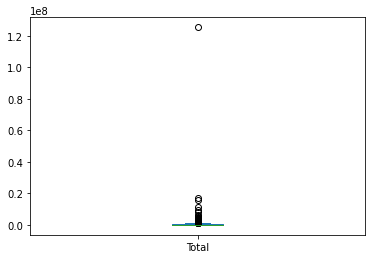

In [101]:
lic_obras_Inex_2020['Total'].plot.box()
plt.show()

In [102]:
lic_obras_Inex_2020['Total'].describe()

count    5.040000e+02
mean     7.957303e+05
std      5.746385e+06
min      1.000000e-02
25%      4.192275e+03
50%      6.586329e+04
75%      5.735850e+05
max      1.253688e+08
Name: Total, dtype: float64

In [103]:
lic_compras_Inex_2020['Tipo'].value_counts()

Compras/Servicos    16889
Name: Tipo, dtype: int64

<AxesSubplot:>

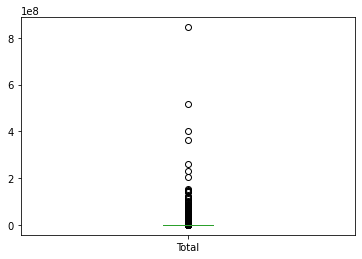

In [104]:
lic_compras_Inex_2020['Total'].plot.box()

In [105]:
lic_compras_Inex_2020['Total'].describe()

count    1.688900e+04
mean     8.258457e+05
std      1.071186e+07
min      1.000000e-02
25%      1.785720e+03
50%      9.027000e+03
75%      6.420567e+04
max      8.447837e+08
Name: Total, dtype: float64

In [106]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_Inex_2020['Tag'] = 1
lic_compras_Inex_2020['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/1596747229.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Inex_2020['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/1596747229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Inex_2020['Tag'] = 1


In [107]:
lic_obras_Inex_2020['Tag'].value_counts()

1    504
Name: Tag, dtype: int64

In [108]:
lic_compras_Inex_2020['Tag'].value_counts()

1    16889
Name: Tag, dtype: int64

## Concurso

In [109]:
df_lic_2020_concurso = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Concurso']

In [110]:
df_lic_2020_concurso['Modalidade Compra'].value_counts()

Concurso    8
Name: Modalidade Compra, dtype: int64

In [111]:
df_lic_2020_concurso['Tipo'].value_counts()

Compras/Servicos    7
Obras               1
Name: Tipo, dtype: int64

In [112]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concurso_2020 = df_lic_2020_concurso[df_lic_2020_concurso['Tipo'] == 'Obras']
lic_compras_concurso_2020 = df_lic_2020_concurso[df_lic_2020_concurso['Tipo'] != 'Obras']

In [113]:
lic_obras_concurso_2020['Tipo'].value_counts()

Obras    1
Name: Tipo, dtype: int64

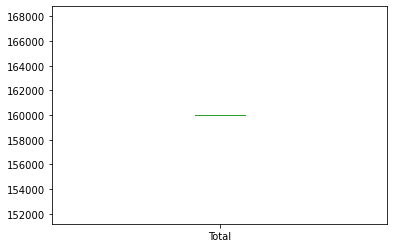

In [114]:
lic_obras_concurso_2020['Total'].plot.box()
plt.show()

<AxesSubplot:>

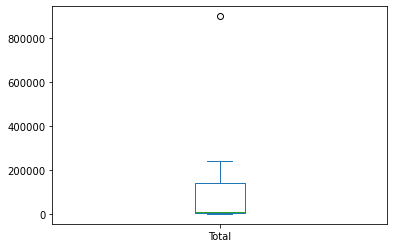

In [115]:
lic_compras_concurso_2020['Total'].plot.box()

In [116]:
lic_compras_concurso_2020['Total'].describe()

count         7.000000
mean     171471.428571
std      332638.150319
min           0.000000
25%        4400.000000
50%        6500.000000
75%      142500.000000
max      900000.000000
Name: Total, dtype: float64

In [117]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concurso_2020['Tag'] = 1
lic_compras_concurso_2020['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/2511420479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_concurso_2020['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_23052/2511420479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_concurso_2020['Tag'] = 1


In [118]:
lic_obras_concurso_2020['Tag'].value_counts()

1    1
Name: Tag, dtype: int64

In [119]:
lic_compras_concurso_2020['Tag'].value_counts()

1    7
Name: Tag, dtype: int64

### Concorrência Internacional

In [120]:
df_lic_2020_concorrencia_internacional = df_lic_2020[df_lic_2020['Modalidade Compra'] == 'Concorrência Internacional']

In [121]:
df_lic_2020_concorrencia_internacional['Modalidade Compra'].value_counts()

Concorrência Internacional    1
Name: Modalidade Compra, dtype: int64

In [122]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concorrencia_internacional_2020 = df_lic_2020_concorrencia_internacional[df_lic_2020_concorrencia_internacional['Tipo'] == 'Obras']
lic_compras_concorrencia_internacional_2020 = df_lic_2020_concorrencia_internacional[df_lic_2020_concorrencia_internacional['Tipo'] != 'Obras']

In [123]:
lic_obras_concorrencia_internacional_2020['Tipo'].value_counts()

Series([], Name: Tipo, dtype: int64)

In [124]:
lic_compras_concorrencia_internacional_2020['Tipo'].value_counts()

Compras/Servicos    1
Name: Tipo, dtype: int64

<AxesSubplot:>

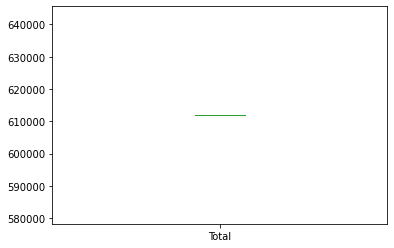

In [125]:
lic_compras_concorrencia_internacional_2020['Total'].plot.box()

In [126]:
lic_compras_concorrencia_internacional_2020['Total'].describe()

count         1.0
mean     611926.7
std           NaN
min      611926.7
25%      611926.7
50%      611926.7
75%      611926.7
max      611926.7
Name: Total, dtype: float64

In [127]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concorrencia_internacional_2020['Tag'] = 1
lic_compras_concorrencia_internacional_2020['Tag'] = 1

In [128]:
lic_obras_concorrencia_internacional_2020['Tag'].value_counts()

Series([], Name: Tag, dtype: int64)

In [129]:
lic_compras_concorrencia_internacional_2020['Tag'].value_counts()

1    1
Name: Tag, dtype: int64

### Salvando todas as analises em uma única base de dados.

In [130]:
lic_2020_com_tag = pd.concat([lic_obras_RP_2020, lic_compras_RP_2020, lic_obras_Dispensa_2020, lic_compras_Dispensa_2020, lic_obras_tomada_de_preco_2020, lic_compras_tomada_de_preco_2020, lic_compras_convite_2020, lic_obras_convite_2020, lic_obras_Pregao_2020, lic_compras_Pregao_2020, lic_obras_Inex_2020, lic_compras_Inex_2020, lic_obras_concurso_2020, lic_compras_concurso_2020, lic_obras_concorrencia_internacional_2020, lic_compras_concorrencia_internacional_2020])

In [131]:
lic_2020_com_tag.to_csv('lic_2020_com_tag.csv')

In [132]:
lic_2020_com_tag['Tag'].value_counts()

1    122413
0     34960
Name: Tag, dtype: int64

In [133]:
lic_2020_com_tag.groupby(['Modalidade Compra','Tag', 'Tipo']).describe()

Número Licitação  \
                                                                 count   
Modalidade Compra                Tag Tipo                                
Concorrência                     0   Compras/Servicos             22.0   
                                     Obras                        20.0   
                                 1   Compras/Servicos             66.0   
                                     Obras                        30.0   
Concorrência - Registro de Preço 0   Compras/Servicos              3.0   
                                     Obras                         1.0   
Concorrência Internacional       1   Compras/Servicos              1.0   
Concurso                         1   Compras/Servicos              7.0   
                                     Obras                         1.0   
Convite                          0   Compras/Servicos             11.0   
                                     Obras                         2.0   
                                 1   Compras/Servicos             22.0   
                                     Obras                        25.0   
Dispensa de Licitação            0   Compras/Servicos          14538.0   
                                     Obras                       466.0   
                                 1   Compras/Servicos          85462.0   
                                     Obras                      1596.0   
Inexigibilidade de Licitação     1   Compras/Servicos          16889.0   
                                     Obras                       504.0   
Pregão                           1   Compras/Servicos          15167.0   
                                     Obras                      1738.0   
Pregão - Registro de Preço       0   Compras/Servicos          19154.0   
                                     Obras                       464.0   
                                 1   Compras/Servicos            441.0   
                                     Obras                        25.0   
Tomada de Preços                 0   Compras/Servicos            152.0   
                                     Obras                       127.0   
                                 1   Compras/Servicos            283.0   
                                     Obras                       156.0   

                                                                     \
                                                               mean   
Modalidade Compra                Tag Tipo                             
Concorrência                     0   Compras/Servicos  4.611077e+04   
                                     Obras             3.251980e+04   
                                 1   Compras/Servicos  1.310201e+06   
                                     Obras             5.868637e+04   
Concorrência - Registro de Preço 0   Compras/Servicos  8.202000e+04   
                                     Obras             8.201800e+04   
Concorrência Internacional       1   Compras/Servicos  9.420200e+05   
Concurso                         1   Compras/Servicos  2.059129e+04   
                                     Obras             2.201900e+04   
Convite                          0   Compras/Servicos  1.838364e+04   
                                     Obras             1.202000e+04   
                                 1   Compras/Servicos  3.701982e+04   
                                     Obras             3.241992e+04   
Dispensa de Licitação            0   Compras/Servicos  1.319300e+07   
                                     Obras             9.415003e+06   
                                 1   Compras/Servicos  1.195931e+07   
                                     Obras             3.580861e+06   
Inexigibilidade de Licitação     1   Compras/Servicos  2.400966e+07   
                                     Obras             3.542020e+06   
Pregão                           1   Compras/Servicos  7.375849e+06   
                                     Obras          

In [134]:
import numpy as np
%matplotlib inline

In [135]:
lic_2020_com_tag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157373 entries, 1072 to 126821
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          157373 non-null  int64  
 1   Código UG                 157373 non-null  int64  
 2   Nome UG                   157373 non-null  object 
 3   Código Modalidade Compra  157373 non-null  int64  
 4   Modalidade Compra         157373 non-null  object 
 5   Número Processo           157373 non-null  object 
 6   Objeto                    157373 non-null  object 
 7   Situação Licitação        157373 non-null  object 
 8   Código Órgão Superior     157373 non-null  int64  
 9   Nome Órgão Superior       157373 non-null  object 
 10  Código Órgão              157373 non-null  int64  
 11  Nome Órgão                157373 non-null  object 
 12  Município                 157373 non-null  object 
 13  Data Resultado Compra     157373 non-null

In [136]:
lic_2020_com_tag['Data Abertura'].value_counts()

25/11/2020    340
24/11/2020    332
29/10/2020    331
17/11/2020    320
27/10/2020    305
             ... 
18/04/2018      1
23/03/2018      1
25/01/2020      1
18/03/2019      1
12/12/2018      1
Name: Data Abertura, Length: 571, dtype: int64